# *\begin{align} Image - Classification - for -Galaxy-Morphologies \end{align}* 
<h3><center>***Liam Wood Roberts***, BrainStation, liamwr17@gmail.com </center></h3>


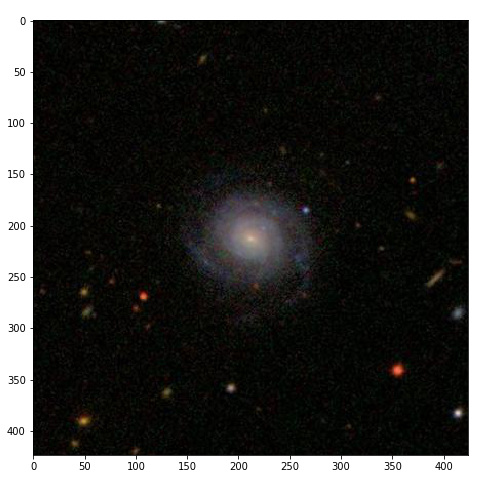


### Table of Contents:
   - [Motivation](#s0)
   - [Introduction](#s1)
   - [Understanding the Data](#s2)
   - [Preprocessing](#s3)
   - [Convolutional Neural Networks](#s4)
   - [Methods for Reducing Overfitting](#s5)
   - [Methods for Reducing Training Time](#s6)
   - [Model Architecture](#s7)
   - [Model Performance](#s8)
   - [Future Work](#s9)
   - [Sources](#s10)
   
   <a id='start'> </a>

In [1]:
#Packages Used
from skimage.io import imread
import keras
import pandas as pd
import numpy as np
import matplotlib
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Conv1D,MaxPooling2D,Dropout,SpatialDropout2D,BatchNormalization
from keras import models
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model, Input
from keras import models

Using TensorFlow backend.



### Motivation: <a id='s0'> </a>

As the number of images being taken to survey surrounding galaxies increases the need for classifying particular galaxies increases as well. Currently many galaxies are classified by crowd sourcing volunteers and having them identify certain shapes and morphologies by hand.  Though this approach has worked in the past it becomes less feasible as the number of images moves into the millions and millions. This project looks at solving this problem through the use of Convolutional Neural Networks in order classify these images in a way that is more scalable to massive data sets.

### Introduction: <a id='s1'> </a>

The objective of this project is to create a model that can classify galaxies as accurately as possible in a way that is scalable to more massive data sets. The data set being used for this project is publically available at:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge

While information regarding the dataset can be found at:

https://arxiv.org/abs/1308.3496

Performance for the model will be measured based off of how closely the models outputs can match the given classifications.

### Understanding the Data: <a id='s2'> </a>

The data set being used to train a classifier consists of 60000 412x412 RGB images. The images are labelled with the percentage voter share from a survey used to classify these galaxies through volunteers. The survey questions are described by the image below.

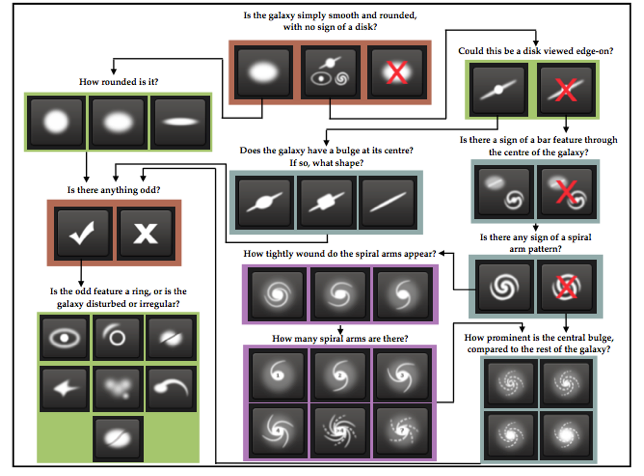

Responses from this survey were aggregated into a list of labels a sample of which is shown below:

In [217]:
def label_loader(file):
    labels = pd.read_csv(file)
    labels.set_index('GalaxyID',inplace = True)
    return labels

labels = label_loader('training_solutions_rev1.csv')
labels.head()

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,
100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


### Preprocessing Images: <a id='s3'> </a>

Images were loaded using the following function

In [22]:
def image_loader(images,y_all,crop=True):
    
    num_train_images = images
    i = 0
    X_orig  = []
    
    for ID in y_all.index:
    
        #import image based on Galaxy ID
        img = f'/Users/LiamRoberts/desktop/Brainstation/DemoProject/images_training_rev1/{ID}.jpg'
        n = imread(img,as_gray=False)
        x,y,channels = n.shape
 
        #Append X_train values
        X_orig.append(n)

        #Break Loop once it reaches desired number of images
        i += 1
        if i == num_train_images:
            break
    
    X_orig = np.float32(X_orig).reshape((int(num_train_images),x,y,channels)) 
    
    y = y_all.values[0:num_train_images]
    X = X_orig
        
    return X/255,y

In [64]:
sample_images = 100
X,y = image_loader(sample_images,labels,crop=False)
print('Image Shape:',X[0].shape)
print('Labels Shape:',y[0].shape)

Image Shape: (424, 424, 3)
Labels Shape: (37,)


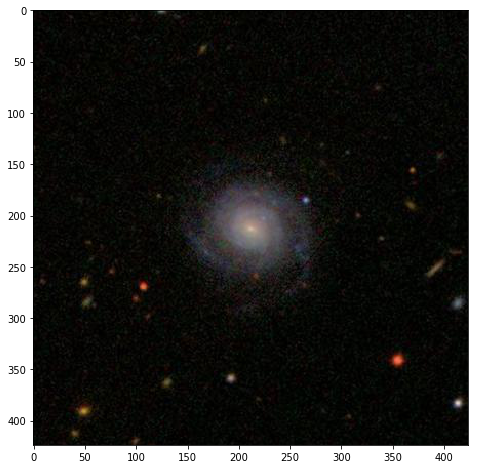

In [208]:
plt.figure(figsize=(8,8))
plt.imshow(X[48]);

The image shows that much of the picture is not particularily useful for classifying the shape of the galaxy. In light of this images were cropped to a more appropriate size of 169x169 while maintaining the centerpoint.

In [209]:
#Import Training Images as flattened np array from:
def crop_image_loader(images,y_all):
    
    num_train_images = images
    i = 0
    X_orig  = []
    for ID in y_all.index:
    
        #import image based on Galaxy ID
        img = f'/Users/LiamRoberts/desktop/Brainstation/DemoProject/images_training_rev1/{ID}.jpg'
        n_uncut= imread(img,as_gray=False)
        x,y,channels = n_uncut.shape
        
        #Crop Images
        n = n_uncut[int(0.3*x):int(0.7*x),int(0.3*y):int(0.7*y)]  
        
        #Append X_train values
        X_orig.append(n)

        #Break Loop once it reaches desired number of images
        i += 1
        if i == num_train_images:
            break
    
    X_orig = np.float32(X_orig).reshape((int(num_train_images),int(x*0.4),int(y*0.4),channels)) 
    
    y = y_all.values[0:num_train_images]
    X = X_orig
    
    return X/255, y

In [210]:
cropped_sample_images = 100
X_cropped,y = crop_image_loader(cropped_sample_images,labels)
print('Image Shape:',X_cropped[0].shape)
print('Labels Shape:',y[0].shape)

Image Shape: (169, 169, 3)
Labels Shape: (37,)


Cropping the images provided images that were much less sparse.

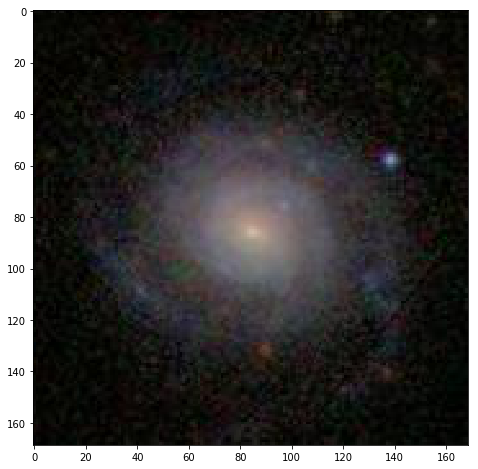

In [211]:
plt.figure(figsize=(8,8))
plt.imshow(X_cropped[48]);

Resizing the images in this way ensures that future models will not have to deal with a massive number of input features that will not help it classify the types of galaxy morphologies.

### Greyscale and Standard Scaling Images:

Preliminary testing showed only a marginal increase in accuracy when using the full RGB image instead of a simple grey scale version. Therefor as computation time was a major concern the images were converted to greyscale, reducing the dimensionality of the image by a factor of three. In addition to this images were standard scaled. This process along with the process for creating a train test split of the data was done using the following function:

In [212]:
def format_images(X,y,scale=True):
    #Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
    train_shape = X_train.shape
    test_shape = X_test.shape
    
    #Unroll X
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
    
    #Standard Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Reshape X
    X_train = X_train.reshape(train_shape)
    X_test = X_test.reshape(test_shape)
    
    print('X_train shape:',X_train.shape)
    print('X_test shape:',X_test.shape)
    print('y_train shape:',y_train.shape)
    print('y_test shape:',y_test.shape)
    
    return X_train, X_test, y_train, y_test

This creates images such as the one below (color added artificially):
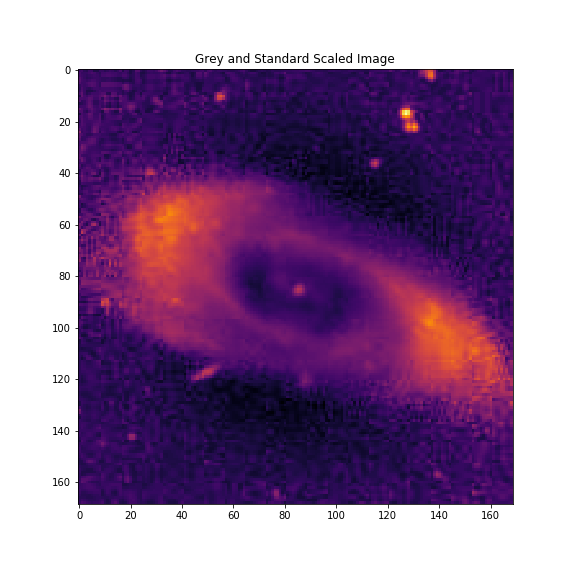


### Convolutional Neural Networks: <a id='s4'> </a>

Competitions for classifying images played a large part in the huge boom of intrest in Convolutional Neural Networks and deep network architectures. One of the most instructive examples of how much Convolutional Neural Networks changed image recognition is thier success on the ImageNet Challenge. In 2011 a "good" image classifier could achieve an error rate of around on 25% on this challenge [1]. In 2012 a deep CNN redefined the definition of an effective image classifier by achieving an error rate of 16%. This triggered a boom of research into deep CNN architectures with modern architectures able to achieve error rates less than 5% [1].

**Baseline Model:** In order to determine how effective the model solutions are at classifying galaxies a "simple" five layer convolutional network was created (Three Concolutional Layers followed by two dense layers) for later comparison. The model was trained on 5000 images in order to determine how effective a relatively simple network could perform on this problem. Due to time constraints this project focused on answering the just the first question of the survey that is: 

"Is the object a smooth galaxy, a galaxy with features, or a star?"

In [213]:
input_shape = X_cropped[0].shape
num_classes = 3

#Summary of Baseline CNN_model
CNN_model = Sequential()
CNN_model.add(Conv2D(32,(5,5),padding='same',strides=(2,2),input_shape=(input_shape)))
CNN_model.add(Activation('relu'))
CNN_model.add(Conv2D(64, (5, 5), strides = (2,2),activation='relu'))
CNN_model.add(Conv2D(128, (5, 5), strides = (2,2),activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(1000, activation='relu'))
CNN_model.add(Dense(num_classes, activation='softmax'))
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 85, 85, 32)        2432      
_________________________________________________________________
activation_6 (Activation)    (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 41, 41, 64)        51264     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 19, 19, 128)       204928    
_________________________________________________________________
flatten_18 (Flatten)         (None, 46208)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 1000)              46209000  
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 3003      
Total para

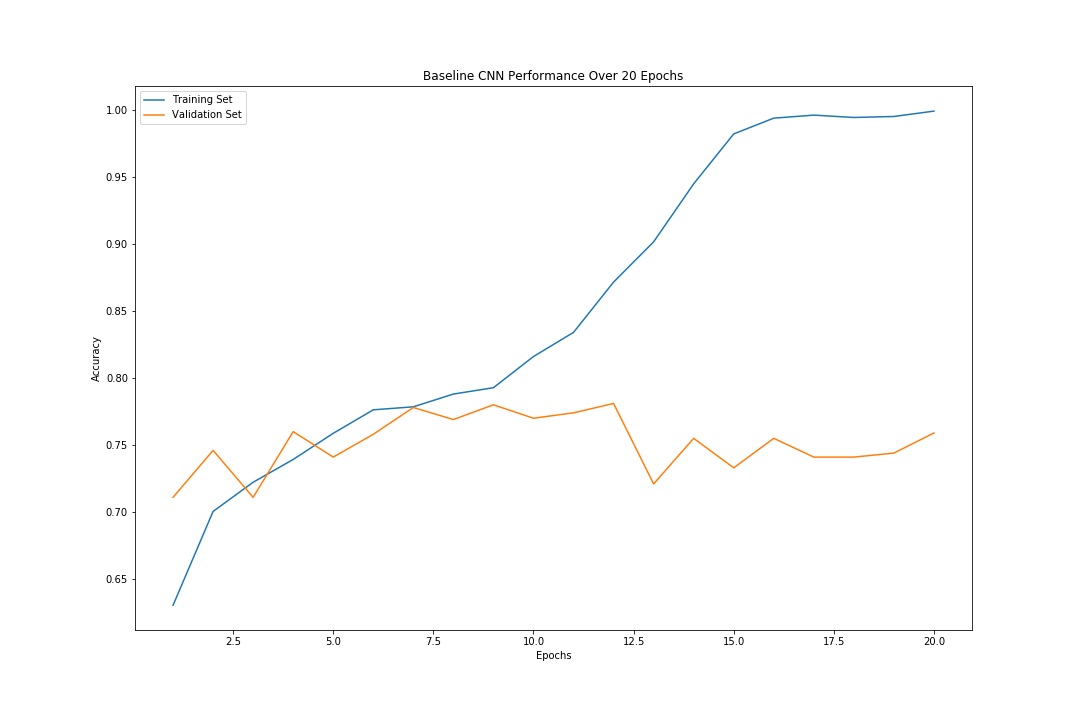

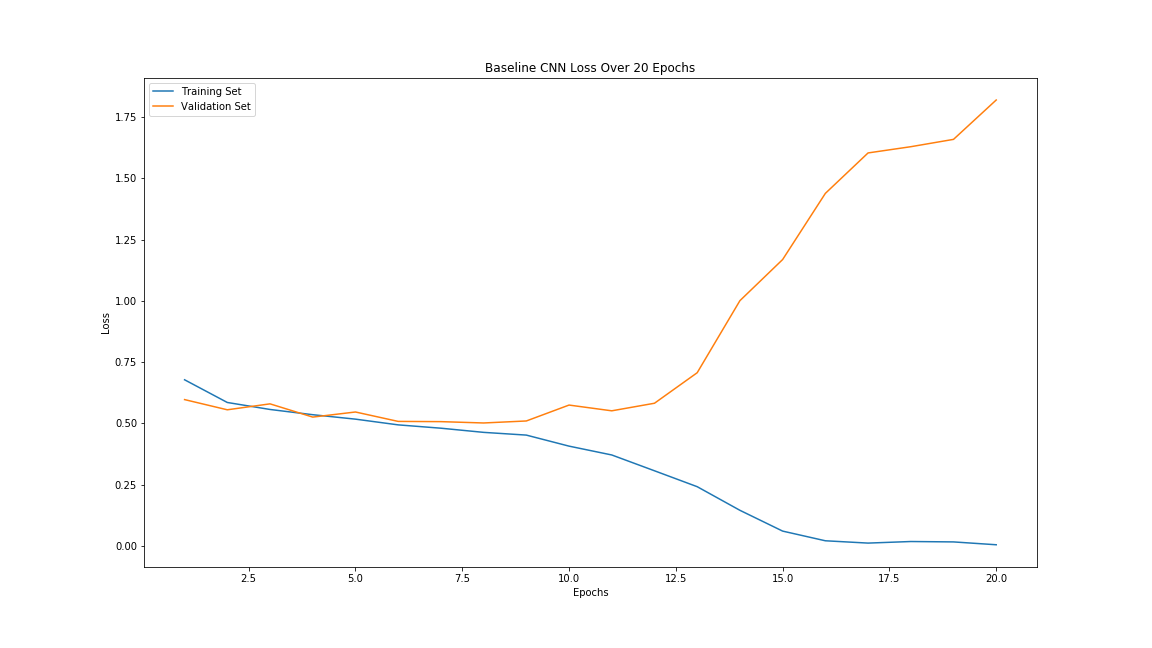

Starting at around 7 passes through the data the simple CNN model begins to over fit the data peaking at a validation set accuracy of 78%. The plot of the loss function reenforces this trend showing a divergence between the training set loss and the test set loss around the same point.

<a id='s5'> </a>
### Methods for Reducing Overfitting:

**Increasing the Amount of Data:**
The most obvious method for reducing overfitting is to feed more data into the model. The current data set consists of 60000 labeled images which can be used for training. In addition to this the number of images can be further increased by adding augmented images to train on. Using this method can allow models to train on orders of magnitude more images than the ones provided. A key transform for this model would be the use of rotation to augment the images. A galaxy rotated in any direction would still be classified as the same type by a human, therefor rotation is a simple way to create additional images to train the network in a way that won't jeopradize the integrity of the labels.

**Adding Dropout Layers:**
One of the key drawbacks of CNNs is their tendancy to overfit training data [2]. One method for combating this that has been shown to be consistently effective is the addition of dropout layers to the network. Dropout layers force the network to forget or "drop" random neuron parameters in each pass of forward and back propogation forcing the network to converge on robust solutions rather than get fixated on certain features [2].



<a id='s6'> </a>
### Methods for Faster Training:

**Rectified Linear Units (ReLu):**
Rectified linear units have become a popular subsititute to the previously used hyperbolic tangent activation function. They have been shown to be much quicker for training models when compared to hyperbolic tangent and do not require data to be normalized before being passed to [2].

**Dimensionality Reducion:**
The most obvious method for reducing train time so far was croping the images. Going from a 424x424x3 image to a 169x169x1 image reduced the dimensionality of the input by roughly a factor of 19. This means the model will have to learn far less parameters when attempting to fit the data which in turn translates to less training time.

**Normalizing Outputs**
Another method for reducing the time needed for networks to converge is to normalize the outputs between layers of the network. Though the activation functions used between each layer ('relu') do not necessarily need to be normalized this is still an effective way to speed up the training time of the model [2].

<a id='s7'> </a>
### Model Architecture:


**Input:**

To reduce the number of parameters needed in the model images were cropped to 169x169x1 before being passed into the model. A sample 169x169 image can be viewed below:

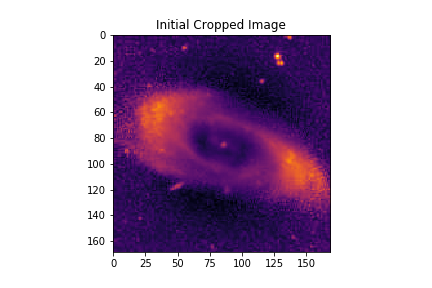

**First Layer:**

The models architecture draws largely from the architecture of AlexNet, but with a greatly reduced number of parameters and no parallelized layers[2]. The first layer is a convolutional layer with 32 filters of window size 11x11 taking 4x4 strides. The outputs of this layer were activated using rectified linear units (all layers with the exception of the final output layer were also activated in this manner) then pooled and batch normalized before being fed into the second convolutional layer.

This first layer serves as a form of feature detection. The activations of this first layer are visualized below to show the output that will be fed into the second layer. These images show how the model is able to pick out such features as the spiral structure of galaxies.

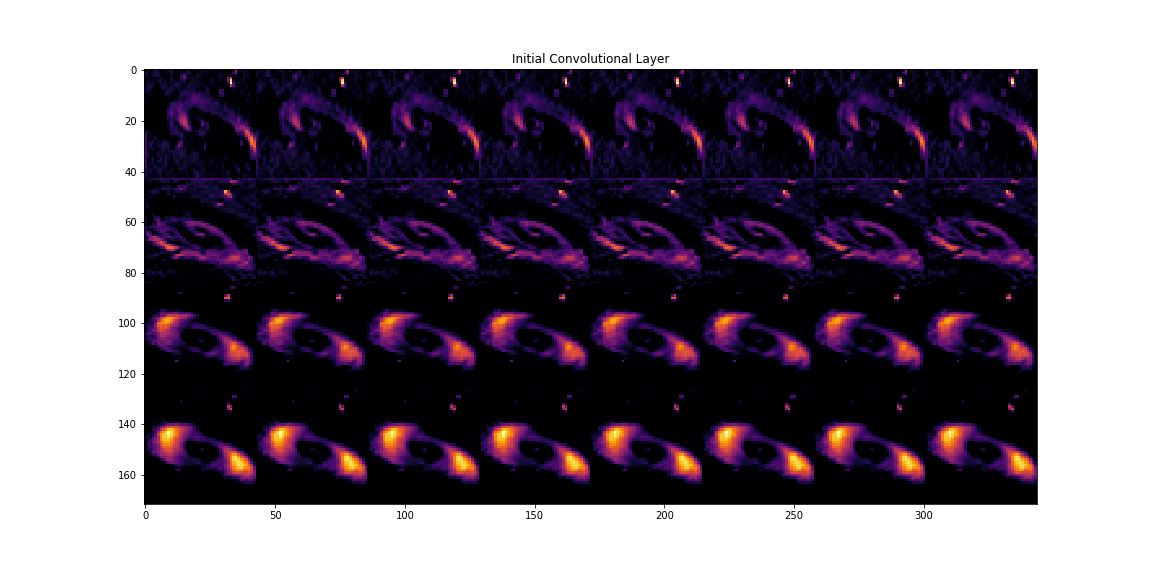
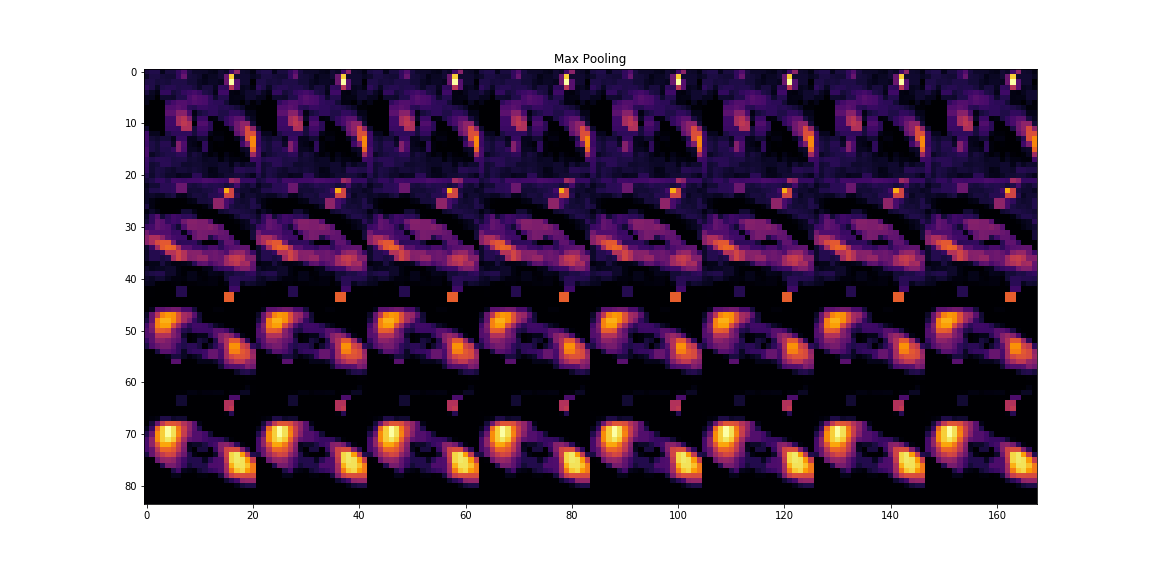
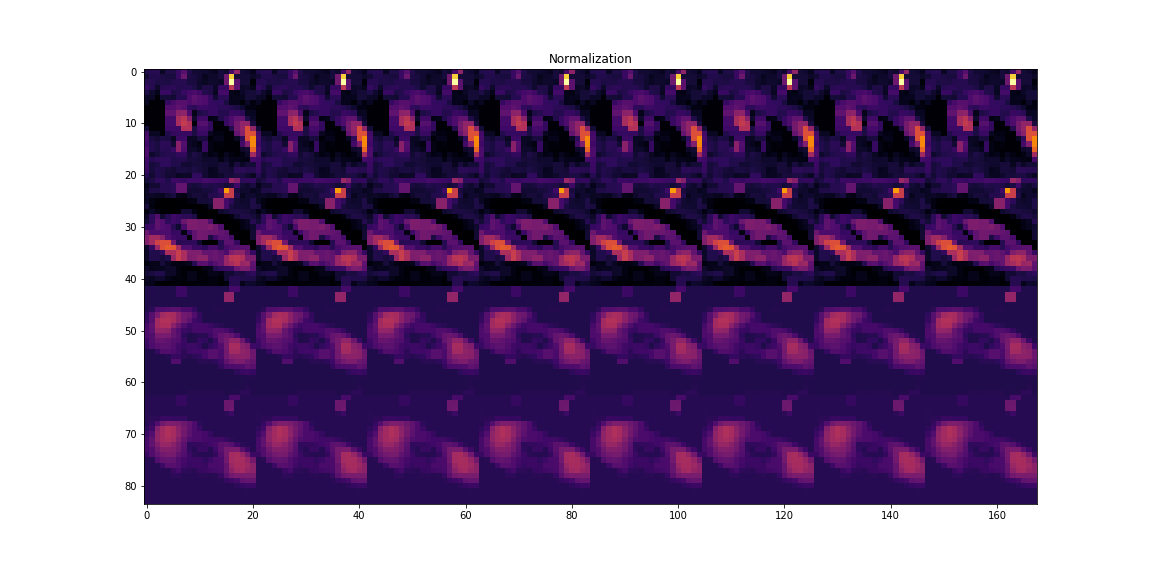

**Second Layer:**

The second layer of the model is another convolutional later with 64 filters of size 5x5 taking single strides. The outputs are again pooled and normalized in the same manner described in the first layer before being passed into the third convolutional layer.

**Third, Forth and Fifth Layers:**

The third, forth and fifth layers are all convolutional layers of the same structure. They are composed of 128 3x3 filters whose outputs are fed directly into the next sequential layer. The outputs of the final convolutional layer are flattened to a 1D array before being passed to the sixth layer.

**Sixth and Seventh Layers:**

The sixth and seventh layers are dense layers composed of 512 units. A dropout filter of 0.5 is applied to the outputs of both of these layers as a means to reduce overfitting.

**Eigth Layer:**

The final layer of the model is set to the number of possible outputs of the particular survey question. For the first survey question there are three possible answers so a model for question one has three dense units. This output is then transformed by a softmax activation function to produce the models prediction of each image.

In [215]:
#In Keras this was written as

model = Sequential()

model.add(Conv2D(32,(11,11),padding='same',activation='relu',strides=(4,4),input_shape=input_shape))
model.add(MaxPooling2D((3, 3),strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5),activation='relu'))
model.add(MaxPooling2D((3, 3),strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(Conv2D(128, (3, 3),activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 43, 43, 32)        11648     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 17, 17, 64)        51264     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 6, 6, 128)         73856     
__________

### Optimizer

This model utilizes the Adam optimizer to train its network. Adam is a form of stochastic gradient descent which has gained popularity in recent years for its speed and efficiency compared to other stochastic methods such as RMSProp and AdaGrad [3]. Furthermore Adam was made specifically with deep networks in mind to account for noise that can be generated from such things as the addition of dropout layers [3]. The parameters were set to initial values recommended by the makers of Adam however optimization of these parameters is something to be explored in future models [3]:


*\begin{align} Learning Rate = 0.001 \end{align}*

*\begin{align} B_1 = 0.9 \end{align}*

*\begin{align} B_2 = 0.999 \end{align}*

*\begin{align} epsilon = 1/10^8 \end{align}*

<a id='s8'> </a>
### Model Performance

Compared to the baseline, the model was able to train much quicker and achieve better results. Training on 5000 images the model achieved the following accuracies and losses.

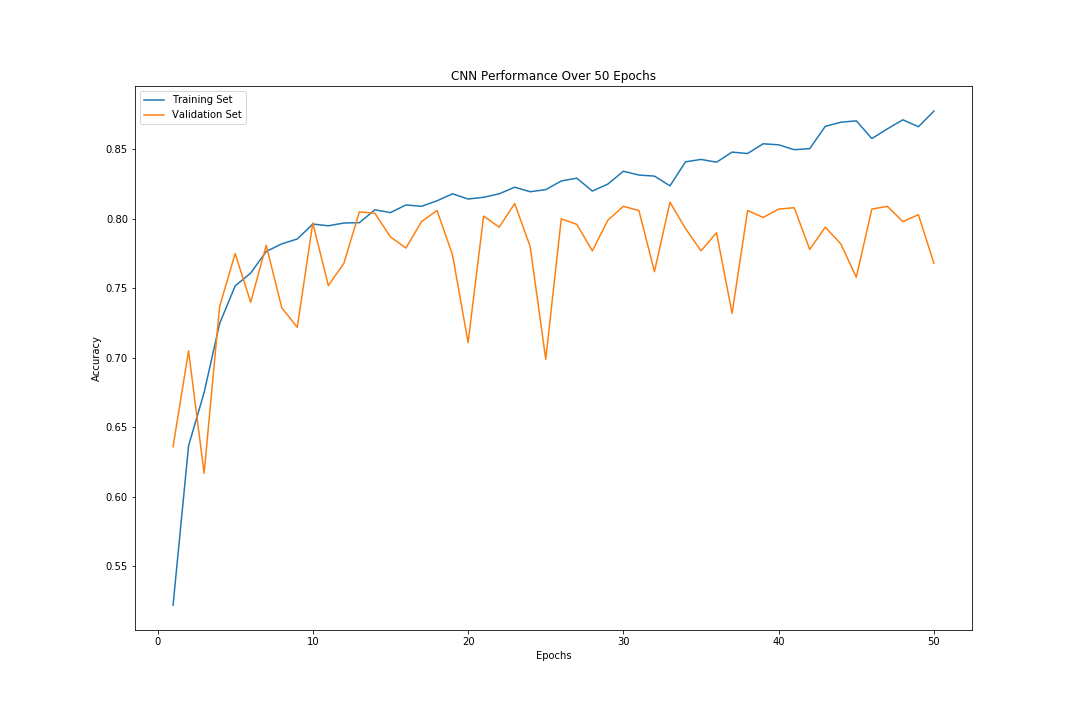

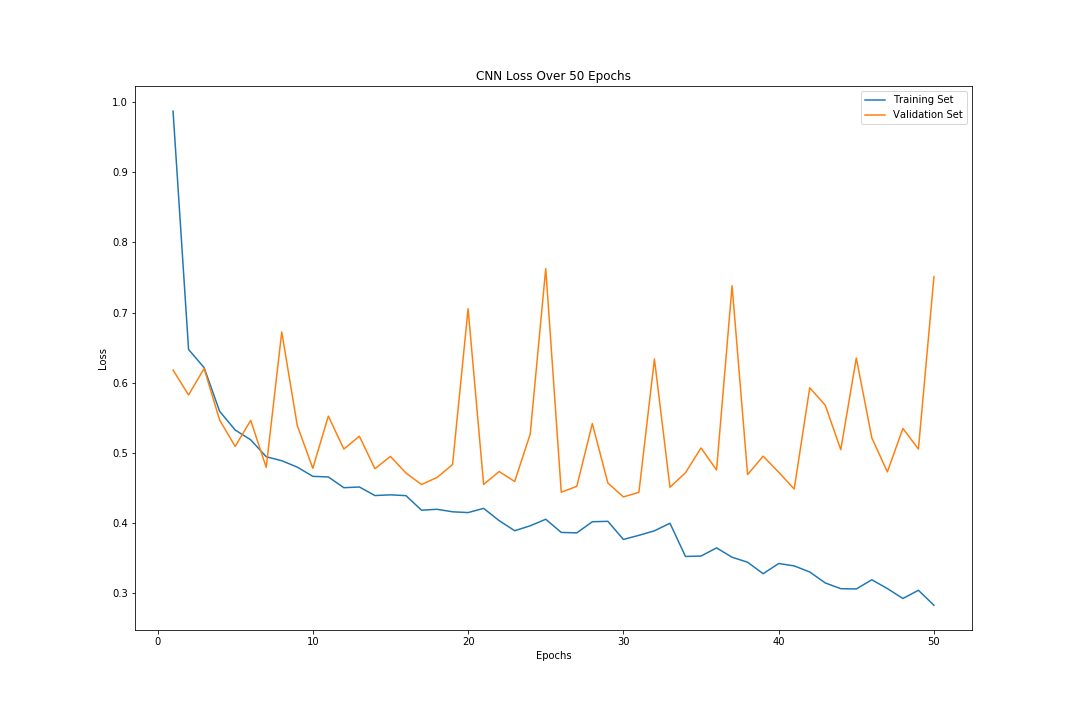

The model converged after around 15 epochs with solutions past this achieving validation set accuracies up to around 80%. One of the key improvements of the model over the baseline is in its training time. The baseline took between 191-234 seconds per pass through the data while the improved model took just 45-60 seconds per pass through the data when running on the same hardware. Though the model achieved higher accuracies overall the variance in accuracy between each epoch indicated that the solution was not very robust and accuracy was dependent on which parameters were forgotten in each dropout layer.

### Training on More Data:

Increasing the image set from 5000 to 20000 images increased the accuracy of the model by roughly 3%. In addition to increasing the overall accuracy the model was also much less prone to "spikes" in both loss and accuracy over each pass through the data indicating that more data allows the network to develop more robust means of classification.

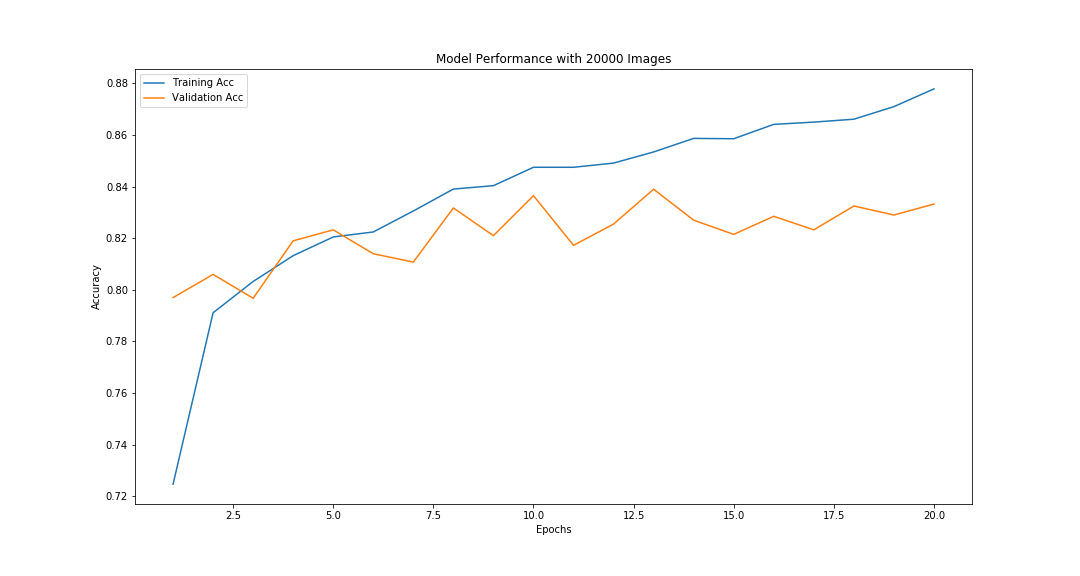
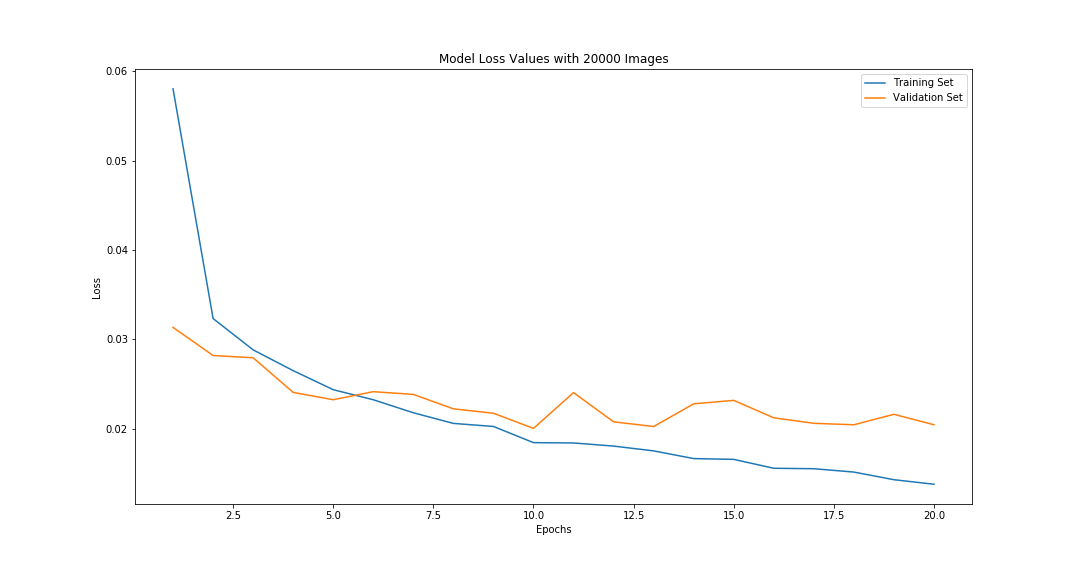

Overall this model was able to far outperform the baseline network. The highest accuracy reached by the model was 84%, an accuracy 7% higher than anything achieved by the baseline. It also stayed far more consistent across each pass through the data maintaining an accuracy of around ~82% on the validation set. It should also be noted that even when training on 20000 images this model took less time per pass through of the data than the baseline took on the 5000 images validating the effectiveness of methods used to reduce training time.

<a id='s9'> </a>
### Future Work

**Using Model to Predict other Survey Questions:** Seeing that the model is able to effectively predict the first question shows that it should be capable of answering other questions within the survey. The main difference between the first survey question and the rest of the survey questions is that the sum of the labels for the first question sum to 1 while the others sum to the total of the previous answer within the survey. This means that a softmax is no longer practical for predicting our labels. Replacing this in other models would be a rectified linear unit which will naturally set a lower bound of zero probability. Due to time constraints however the model was not tested on other survey questions.

**Training on More Data:** The most obvious next steps for improving this classifier is to increase the amount of images the network is able train on. This will reduce how much the network overfits the data and lead to lower loss and higher accuracy. Ideally the network would be trained on the full 60000 images with more images being generated through the use of image transformations such as rotation.

**Complex Architectures:** Another proposed methof to improve the model would be to introduce parallelized architectures. Currently the model is completely sequential, that is the outputs of one layer are fed directly into the inputs of the next layer. More modern CNN architectures however often employ more complex network models, examples of these are networks such as Inception and Resnet. An example of an "Inception Module" which utilizes a non sequential architecture is featured below [4].

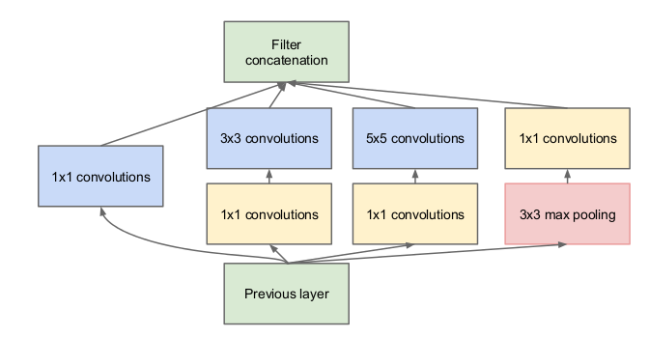

<a id='s10'> </a>
### Sources

[1] - ImageNet, Wikipedia, from: https://en.wikipedia.org/wiki/ImageNet

[2] - Adam: a Method for Stochastic Optimization, Diederik P. Kingma, Jimmy Lei Ba,(OpenAI,University of Toronto),2015, from: https://arxiv.org/abs/1412.6980

[3] - ImageNet Classification with Deep Convolutional Neural Networks, Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, (University of Toronto), 2012,from: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

[4] - Going Deeper with Convolutions, Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich, (Google Inc, University of North Carolina, University of Michigan), 2014, from: https://arxiv.org/abs/1409.4842

[back to top](#start)